In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

In [3]:
import os
import sys
# sys.path.append('/home/thabib/Documents/Personal/Master_Thesis/1_HTMImplementation/ufuncs.py')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import time
import random
import time
import h5py

import ipywidgets as widgets
from ipywidgets import interact, interact_manual, interactive

from rebergrammar_generator import *
from experimentor import Experimentor
from ufuncs import full_pickle, unpickle, compress_pickle, decompress_pickle

os.getcwd()
# np.set_printoptions(threshold=sys.maxsize)

'/home/thabib/Documents/Personal/Master_Thesis/1_HTMImplementation'

### Param Settings (NOTE: Define `trial` carefully, for consistent saving of data later)

In [4]:
# Network params
M = 8
N = 175
k = 25

perm_decrement = 0.01 # p-
perm_increment = 2*perm_decrement # p+
perm_decay = 0.25*perm_decrement # p--
perm_boost = 0.1*perm_decrement # p++

# Cell params
dendrites_percell = 32
connSynapses_perdend = 32 # not functional, at the moment
nmda_threshold = 20
permanence_threshold = 0.40
init_permanence = 0.25
activity_horizon = None
activity_threshold = None

# Task params
do_ERG = False
nof_strings = 2000

trial = 'trial_1'

### Experiment Initializer and Launcher

In [5]:
start = time.time()

exp = Experimentor(M=M, N=N, k=k, n_dendrites=dendrites_percell, n_synapses=connSynapses_perdend, 
                   nmda_th=nmda_threshold, perm_th=permanence_threshold, perm_init=init_permanence, 
                   perm_decrement=perm_decrement, perm_increment=perm_increment, 
                   perm_decay=perm_decay, perm_boost=perm_boost,
                   activity_horizon=activity_horizon, activity_th=activity_threshold,
                   do_ERG=do_ERG, nof_strings=nof_strings)

In [ ]:
dict_results = exp.run_experiment()

print(time.time()-start)

# 3606 secs for 1000 strings
# 19374 secs for 5000 strings
# 7845 secs for 2000 strings

In [ ]:
sys.getsizeof(dict_results['results'])

#### Writing Files

In [ ]:
if do_ERG:
    exp_filename = 'ERG_'+str(nof_strings)+'strings'
else:
    exp_filename = 'SRG_'+str(nof_strings)+'strings'


# USING PICKLE
filename = exp_filename+'_chars_to_minicols'
full_pickle(filename, dict_results['chars_to_minicols'])
filename = exp_filename+'_in_strings_oh'
full_pickle(filename, dict_results['in_strings_onehot'])
filename = exp_filename+'_out_strings_oh'
full_pickle(filename, dict_results['out_strings_onehot'])

filename = exp_filename+'_results'
compress_pickle(filename, dict_results['results'])


#### Loading Files

In [ ]:
if do_ERG:
    exp_filename = 'ERG_'+str(nof_strings)+'strings'
else:
    exp_filename = 'SRG_'+str(nof_strings)+'strings'
    
    
# USING PICKLE
filename = exp_filename+'_chars_to_minicols'
charsMC = unpickle(filename)
filename = exp_filename+'_chars_to_minicols'
in_strings_onehot = unpickle(filename)
filename = exp_filename+'_chars_to_minicols'
out_strings_onehot = unpickle(filename)

filename = exp_filename+'_results'
results = decompress_pickle(filename)
results.set_index('reber_string', inplace=True)

#results = dict_results['results']
#results.set_index('reber_string', inplace=True)

# Analysis of Results

In [ ]:
results

In [ ]:
charsMC

In [ ]:
# Generating xticks for plots based on characters-minicols

xticks_plot = np.empty(N, dtype=object)
for ch in chars:
    xticks_plot[charsMC[ch]] = ch
    
xticks_plot

## 1. Input String Statistics

In [ ]:
%matplotlib inline

In [ ]:
in_strings_alpha = [s for s in list(results.index)]

# NOF TOTAL CHARACTERS in the input stream
tot_len_in = 0
for string in in_strings_alpha:
    tot_len_in += len(string)

# NOF STRINGS with a given CONTEXT
context = 'APVPVZ'


# Plotting HISTOGRAM of REBER STRING's LENGTH
len_rg_exs = []

for ex in in_strings_alpha:
    len_rg_exs.append(len(ex))



print(f'A total of {len(in_strings_alpha)} strings were generated. \n\n\
With: \n\
NOF Unique Strings = {len(np.unique(in_strings_alpha))}. \n\
NOF characters in total = {tot_len_in}. \n\
NOF strings with context {context} = {sum([i.startswith(context) for i in in_strings_alpha])}. \n\
Mean length of string = {np.mean(len_rg_exs)}. \n\
Median length of string = {np.median(len_rg_exs)}.')

plt.figure()
plt.hist(len_rg_exs)
plt.show()

## 2. Network Activity & Predictivity

### Computing Cellular Activity & Predictivity

In [88]:
%matplotlib notebook

<IPython.core.display.Javascript object>


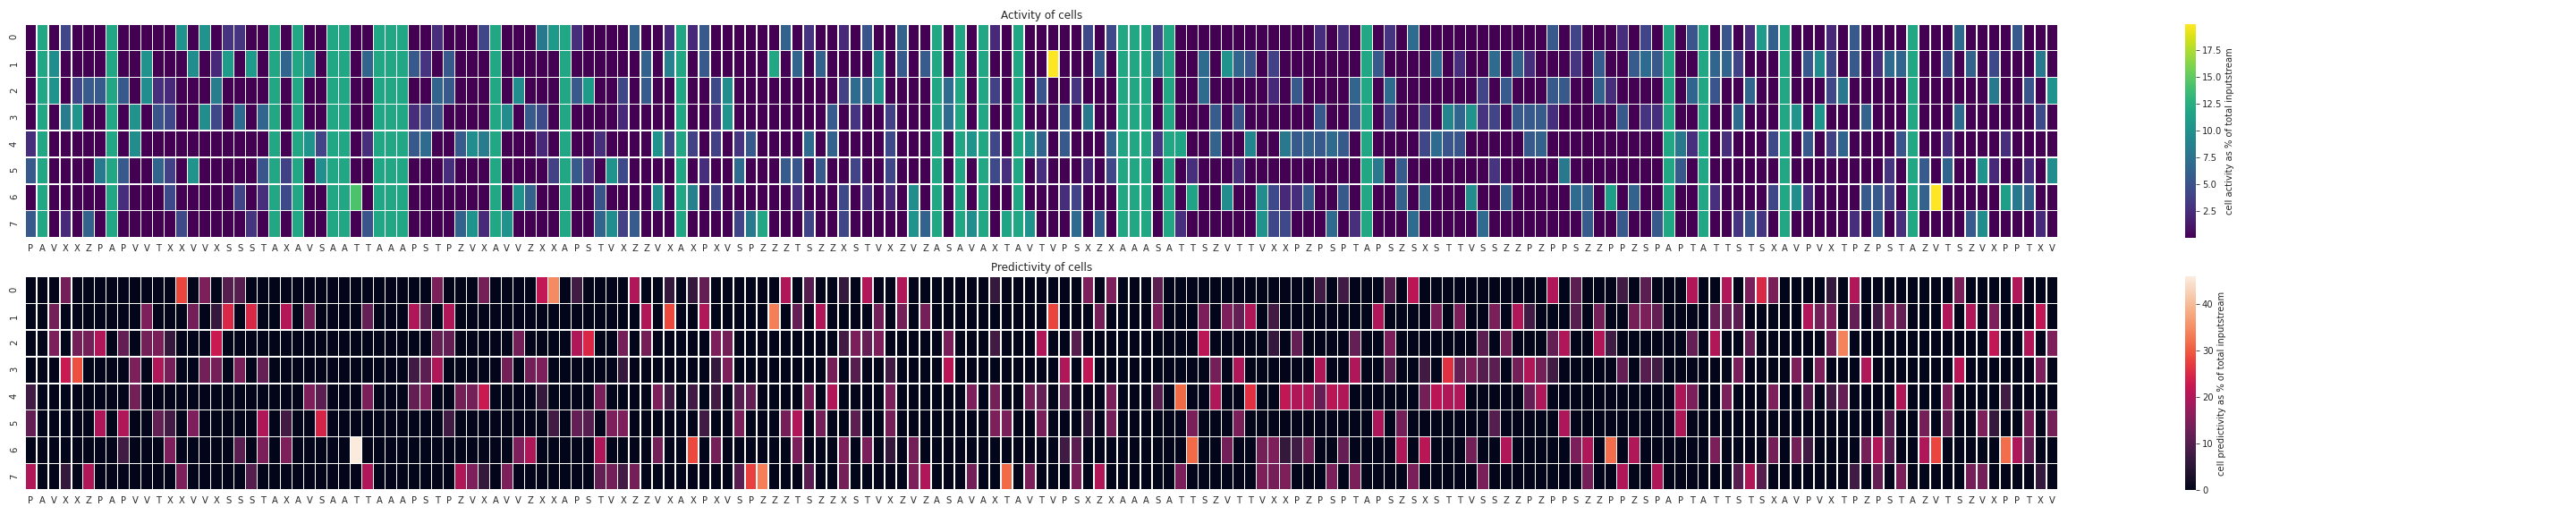

In [124]:
cell_activity = np.zeros([M,N])
for string_idx in range(len(in_strings_alpha)):
    cell_activity += sum(results.iloc[string_idx]['htm_states']) # RHS sums up the net cellular activity 
                                                                 # for each letter of the string.
cell_predictivity = np.zeros([M,N])
for string_idx in range(len(in_strings_alpha)):
    cell_predictivity += sum(results.iloc[string_idx]['htm_preds'])

# Normalizing the net cellular predictivity of each cell
cell_predictivity = (cell_predictivity/tot_len_in)*100
# Normalizing the net cellular activity of each cell
cell_activity = (cell_activity/tot_len_in)*100

sns.set_style("whitegrid")
fig, axes = plt.subplots(2,1, sharex=False, figsize=(40,8))

sns.heatmap(cell_activity, linewidth=0.5, cmap='viridis', xticklabels=xticks_plot, 
            ax=axes[0], cbar_kws={'label':'cell activity as % of total inputstream'})
axes[0].set_title('Activity of cells')

sns.heatmap(cell_predictivity, linewidth=0.5, xticklabels=xticks_plot,
            ax=axes[1], cbar_kws={'label':'cell predictivity as % of total inputstream'})
axes[1].set_title('Predictivity of cells')

axes[0].set_xticklabels(labels=xticks_plot, rotation=0)
axes[1].set_xticklabels(labels=xticks_plot, rotation=0)
plt.tight_layout()
plt.show()

### Cell Activity & Predictivity – Character-wise

<IPython.core.display.Javascript object>


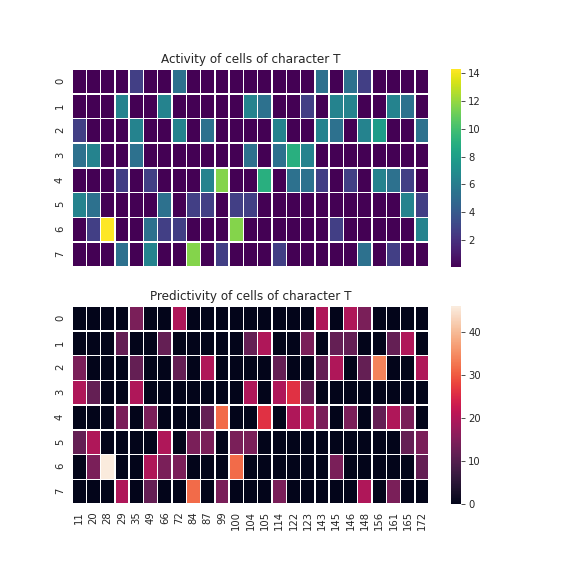

Character-wise Activity: 

 [[ 0.05340929  0.05340929  0.05340929  0.05340929  2.68233339  0.05340929
   0.05340929  5.28752003  0.05340929  0.05340929  0.05340929  0.05340929
   0.05340929  0.05340929  0.05340929  0.05340929  0.05340929  5.28752003
   0.05340929  5.28752003  2.68233339  0.05340929  0.05340929  0.05340929
   0.05340929]
 [ 0.05340929  0.05340929  0.05340929  6.43878702  0.05340929  0.05340929
   6.43878702  0.05340929  0.05340929  0.05340929  0.05340929  0.05340929
   6.43878702  5.28752003  0.05340929  0.05340929  2.68233339  0.05340929
   6.43878702  6.43878702  0.05340929  0.05340929  6.43878702  5.28752003
   0.05340929]
 [ 2.68233339  0.05340929  0.05340929  0.05340929  6.43878702  0.05340929
   0.05340929  6.43878702  0.05340929  5.28752003  0.05340929  0.05340929
   0.05340929  0.05340929  6.43878702  0.05340929  0.05340929  6.43878702
   5.28752003  0.05340929  6.43878702  7.91644413  0.05340929  0.05340929
   5.28752003]
 [ 5.28752003  6.43878702  0.05340929  

In [247]:
char = 'T'

char_activity = cell_activity[:,list(charsMC[char])]
char_predictivity = cell_predictivity[:,list(charsMC[char])]

sns.set_style("whitegrid")
fig, axes = plt.subplots(2,1, sharex=True, figsize=(8,8))

sns.heatmap(char_activity, linewidth=0.5, cmap='viridis', xticklabels=list(charsMC[char]), ax=axes[0])
axes[0].set_title(f'Activity of cells of character {char}')
sns.heatmap(char_predictivity, linewidth=0.5, xticklabels=list(charsMC[char]), ax=axes[1])
axes[1].set_title(f'Predictivity of cells of character {char}')
plt.show()

print('Character-wise Activity: \n\n', char_activity)
print('\n\nCharacter-wise Predictivity: \n\n', char_predictivity)

## 3. Network Properties for a particular Reber string

In [256]:
results

,htm_states,htm_preds,htm_preds_dend,htm_networks
reber_string,,,,
APVPXVSZ,"[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[nan, nan, nan, nan, nan, nan, nan, nan, nan...",[[[<htm_cell.HTM_CELL object at 0x7ff4a01c03d0...
ATSXXVPVZ,"[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[nan, nan, nan, nan, nan, nan, nan, nan, nan...",[[[<htm_cell.HTM_CELL object at 0x7ff4a01c03d0...
ATXXVPVZ,"[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[nan, nan, nan, nan, nan, nan, nan, nan, nan...",[[[<htm_cell.HTM_CELL object at 0x7ff4a01c03d0...
ATXXVSZ,"[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[nan, nan, nan, nan, nan, nan, nan, nan, nan...",[[[<htm_cell.HTM_CELL object at 0x7ff4a01c03d0...
ATXXVSZ,"[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[nan, nan, nan, nan, nan, nan, nan, nan, nan...",[[[<htm_cell.HTM_CELL object at 0x7ff4a01c03d0...
...,...,...,...,...
ATXXVSZ,"[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[nan, nan, nan, nan, nan, nan, nan, nan, nan...",[[[<htm_cell.HTM_CELL object at 0x7ff4a01c03d0...
APVPXVSZ,"[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[nan, nan, nan, nan, nan, nan, nan, nan, nan...",[[[<htm_cell.HTM_CELL object at 0x7ff4a01c03d0...
ATXXVPXVPVZ,"[[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[nan, nan, nan, nan, nan, nan, nan, nan, nan...",[[[<htm_cell.HTM_CELL object at 0x7ff4a01c03d0...


Showing Network properties for string: ATXXVPVZ 




<IPython.core.display.Javascript object>


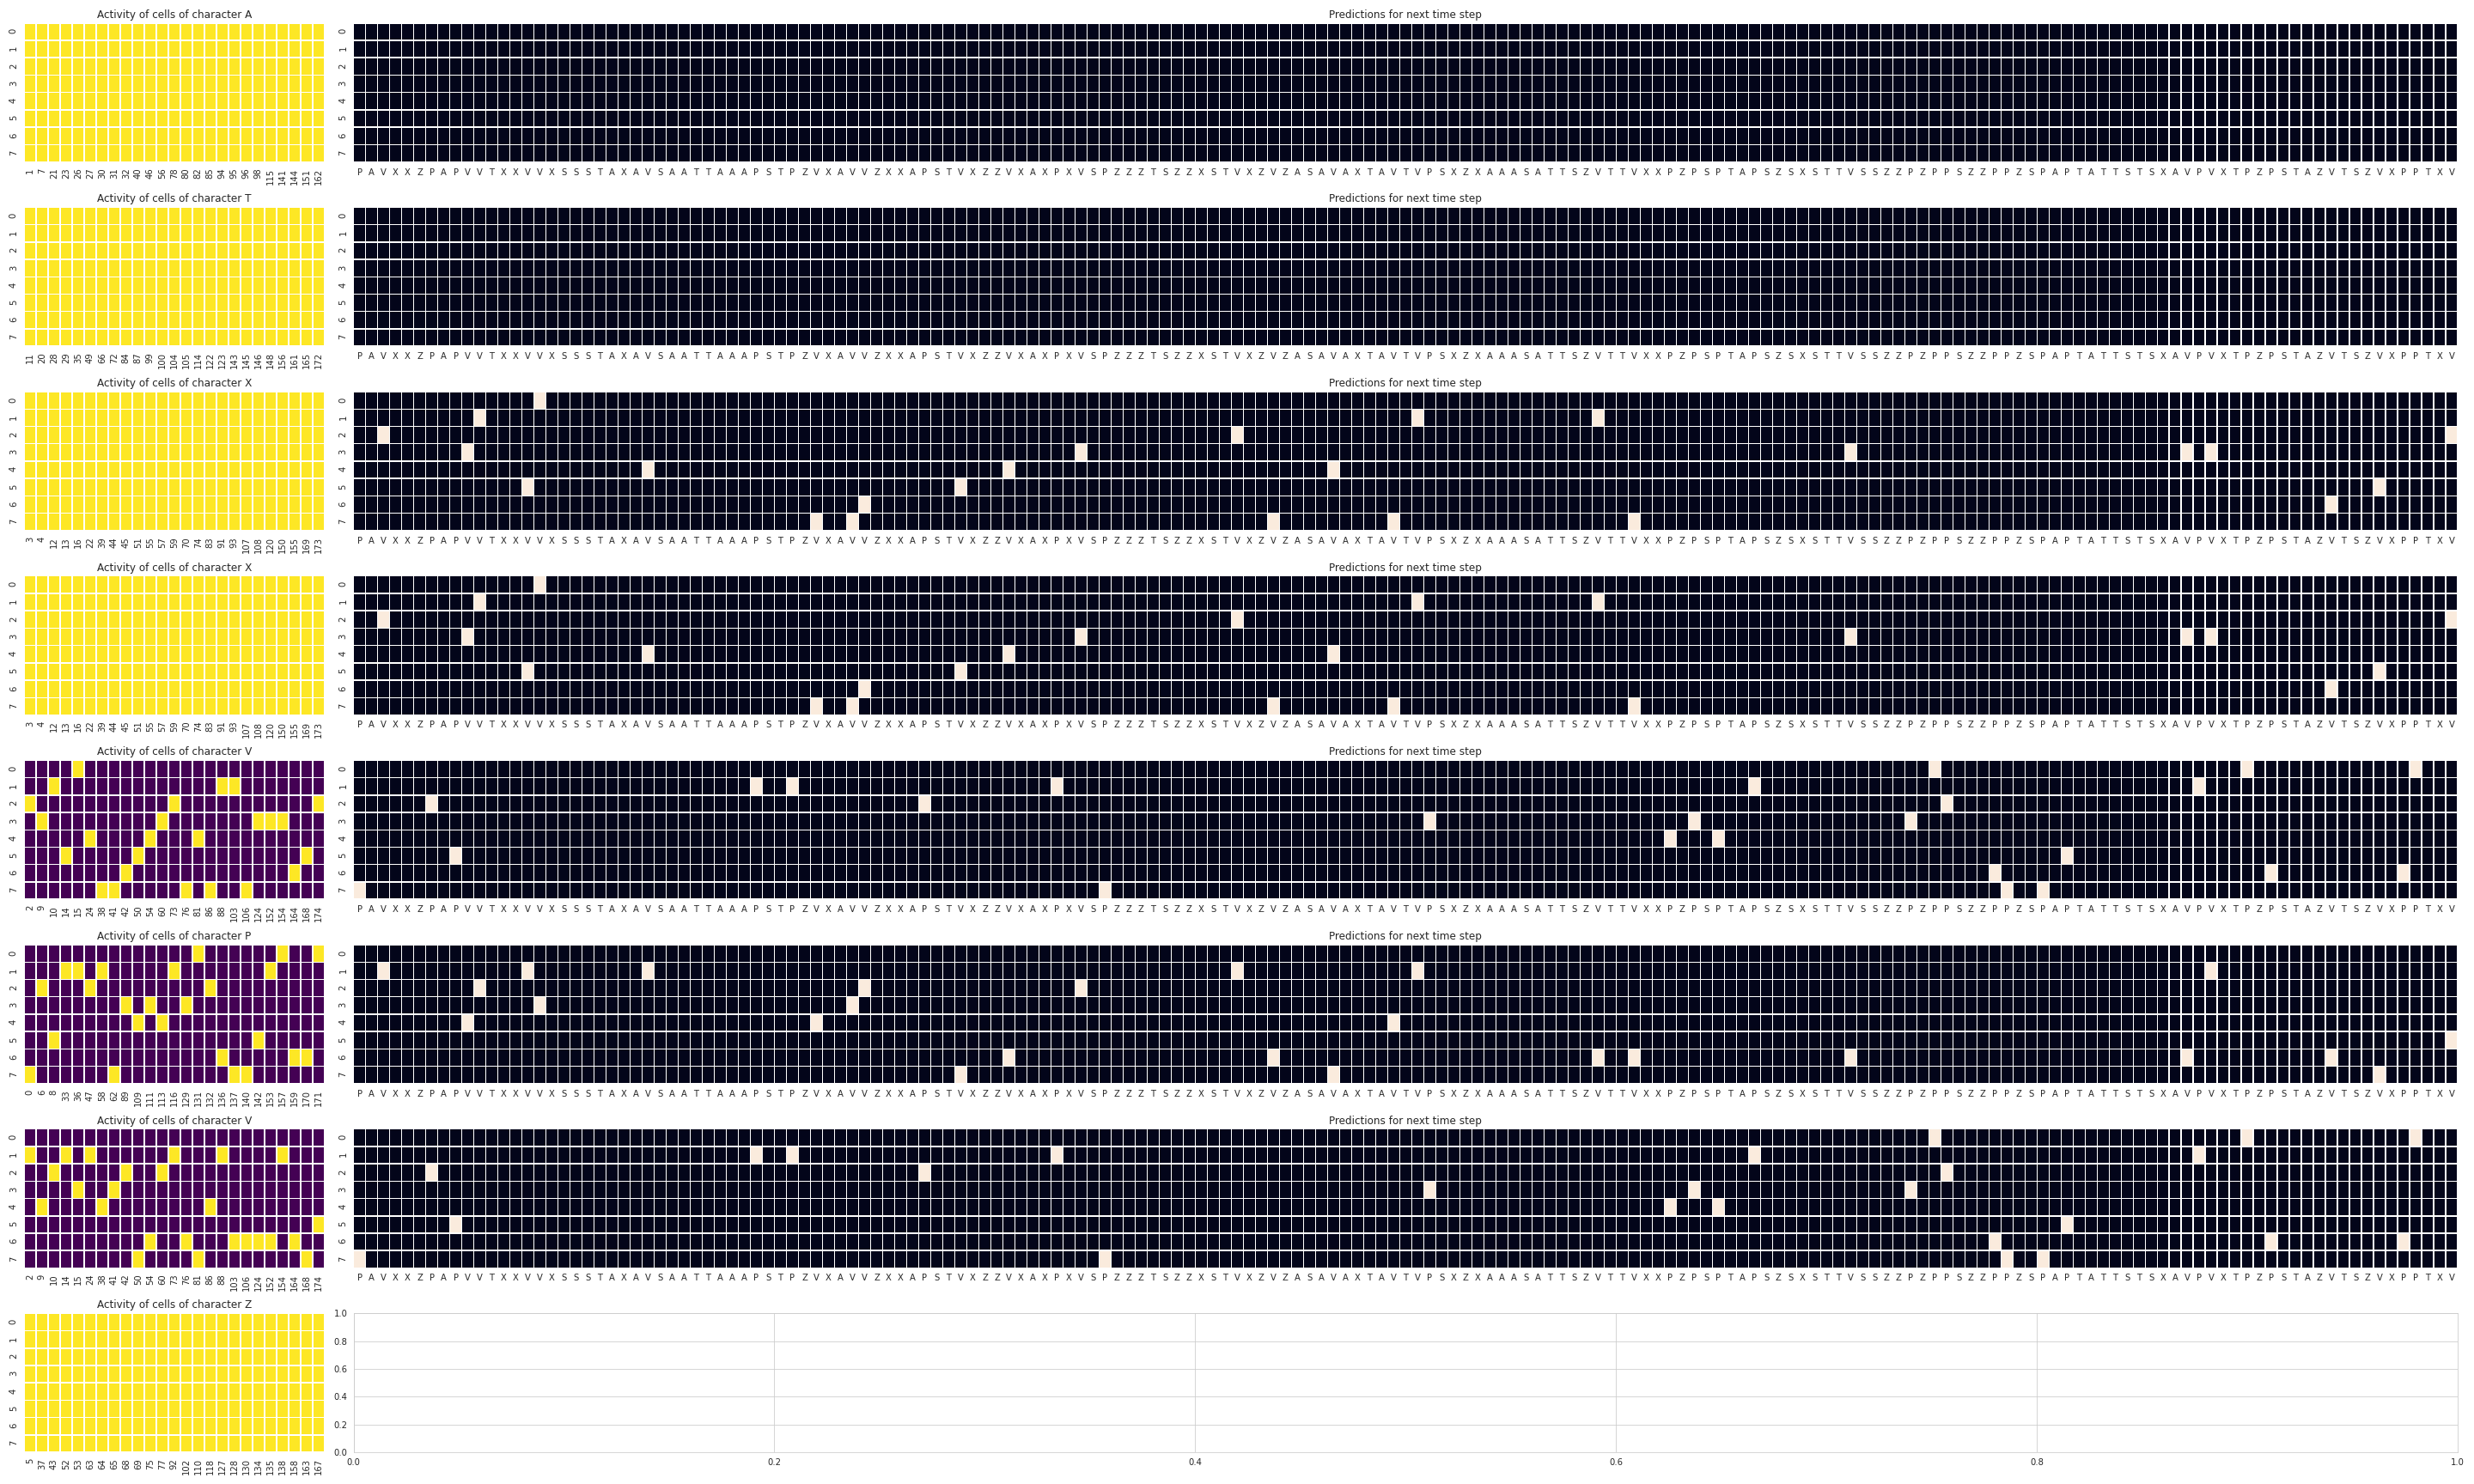

In [258]:
reber_string_idx = 2
reber_string = results.iloc[reber_string_idx].name
res_string = results.iloc[reber_string_idx]

print(f'Showing Network properties for string: {reber_string} \n\n')

sns.set_style("whitegrid")
fig, axes = plt.subplots(len(reber_string),2, figsize=(40,3*len(reber_string)), 
                         gridspec_kw={'width_ratios': [1, 7]})

for i in range(len(reber_string)):
    char = reber_string[i]
    
    # Plot the current step's character's (cell) activity
    sns.heatmap(res_string['htm_states'][i][:, list(charsMC[char])], vmax=1, vmin=0, cbar=False, linewidth=0.5, cmap='viridis', 
                xticklabels=list(charsMC[char]), ax=axes[i][0])
    axes[i][0].set_title(f'Activity of cells of character {char}')
    
    
    if i<len(reber_string)-1:
        
        # Plot the next timestep's predictions
        
        predicted_chars = np.unique([charsMC.columns[np.where(charsMC == idx)[1]][0] 
                  for idx in np.where(res_string['htm_preds'][i])[1]])
    
        multiplying_arr = np.zeros(N)

        for k in range(len(predicted_chars)):
            multiplying_arr[list(charsMC[predicted_chars[k]])] = 1/(k+1)

        plot_predictions=[res_string['htm_preds'][i][j]*multiplying_arr
                          for j in range(M)]

        sns.heatmap(plot_predictions, vmax=1, vmin=0, cbar=False, linewidth=0.5, xticklabels=xticks_plot, ax=axes[i][1])

        axes[i][1].set_title('Predictions for next time step')
        
    else:
        continue
    
plt.tight_layout()
plt.show()

## 4. Measuring Performance

**Prediction Accuracy:** #correctly predicted cols / #predicted cols 
- Prediction accuracy will be 1.0 if there is only 1 column predicted by the network and that one column is one out of the (say) 50 expected predicted columns, because 1/1 = 1.0. 
- Hence, it only makes sense to compute prediction accuracy when the number of columns predicted by the network is higher than the expected number of correctly predicted columns.

**Prediction Performance:**  moving average over the last 100 sequences

### Prediction Accuracy

In [253]:
pred_acc = []

for string_idx in range(len(in_strings_alpha)):
    
    for char_idx in range(len(results.iloc[string_idx]['htm_preds'])):
        
        correct_preds = out_strings_onehot[string_idx][char_idx] # Correct expected predictions for the 
                                                                 # particular <[string_idx][char_idx]> timestep
        
        predicted_cols_idx = np.where(results.iloc[string_idx]['htm_preds'][char_idx])[1] # Indices of the cols
                                                                 # predicted by the network for particular 
                                                                 # <[string_idx][char_idx]> timestep.
        
        if len(predicted_cols_idx) >= np.count_nonzero(correct_preds):
            
            count=0
            for col_idx in np.where(correct_preds)[0]:
                if col_idx in predicted_cols_idx:
                    count+=1
            
            accuracy = count/len(predicted_cols_idx)
            
            pred_acc.append(accuracy)
            
        else:
            pred_acc.append(0)
        

ZeroDivisionError: division by zero

In [254]:
predicted_cols_idx

array([], dtype=int64)

In [ ]:
plt.figure(figsize=(50,3))
plt.plot(pred_acc[35000:])
plt.show()

print('Mean prediction accuracy: ', np.mean(pred_acc))

### Prediction Performance

# :::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::ROUGH::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

<IPython.core.display.Javascript object>


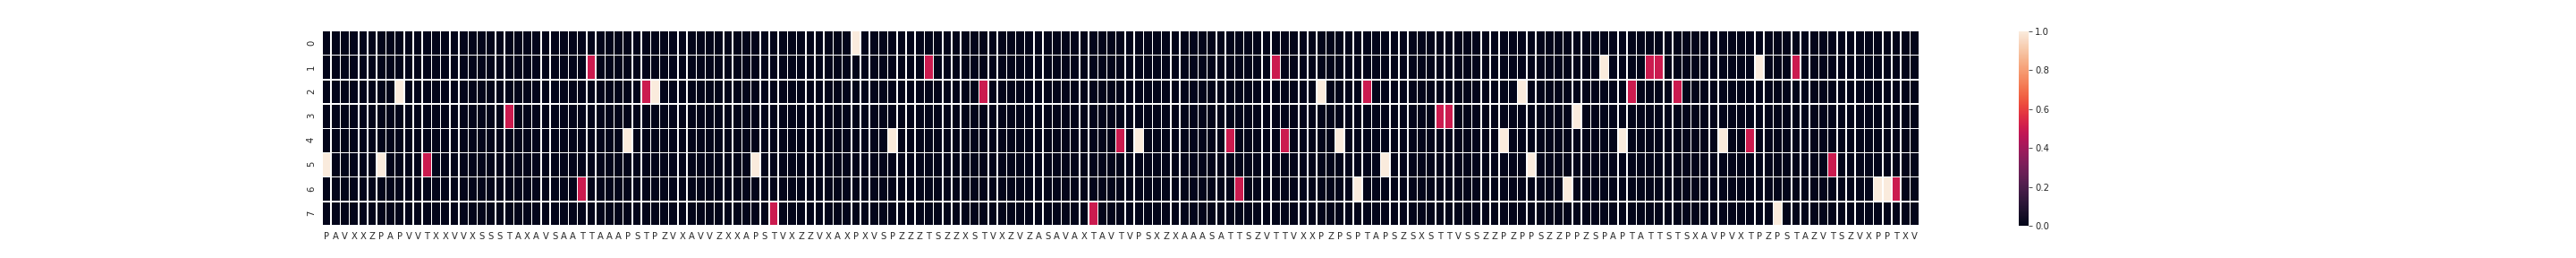

In [234]:
predicted_chars = np.unique([charsMC.columns[np.where(charsMC == idx)[1]][0] 
                  for idx in np.where(results.iloc[999]['htm_preds'][0])[1]])
    
multiplying_arr = np.zeros(N)

for i in range(len(predicted_chars)):
    multiplying_arr[list(charsMC[predicted_chars[i]])] = 1/(i+1)
    
plot_predictions=[results.iloc[999]['htm_preds'][0][i]*multiplying_arr
                  for i in range(M)]
    
sns.heatmap(plot_predictions,linewidth=0.5, xticklabels=xticks_plot)
plt.show()
    

In [225]:
m = np.ones(N)
m[list(charsMC['P'])] = 1/3
m[list(charsMC['T'])] = 1/2
m

array([0.33333333, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.33333333, 1.        , 0.33333333, 1.        ,
       1.        , 0.5       , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.5       , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.5       , 0.5       ,
       1.        , 1.        , 1.        , 0.33333333, 1.        ,
       0.5       , 0.33333333, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.33333333, 1.        , 0.5       ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.33333333, 1.        ,
       1.        , 1.        , 0.33333333, 1.        , 1.        ,
       1.        , 0.5       , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.5       , 1.        , 1.     

In [218]:
charsMC.columns[np.where(charsMC == 6)[1]][0]

'P'

### The entire calculation (step-by-step) for plotting next timestep's predictions in section 3. above

In [235]:
predicted_cols_idx = np.where(res_string['htm_preds'][i])[1]

predicted_char = []
for idx in predicted_cols_idx:
    predicted_char.append(charsMC.columns[np.where(charsMC == idx)[1]][0])

predicted_chars = np.unique(predicted_char)
multiplying_arr = np.zeros(N)

for i in range(len(predicted_chars)):
    multiplying_arr[list(charsMC[predicted_chars[i]])] = 1/(i+1)

plot_predictions=[]
for i in range(M):
    plot_predictions.append(results.iloc[999]['htm_preds'][0][i]*multiplying_arr)

plt.figure(figsize=(40,4))
sns.heatmap(plot_predictions,linewidth=0.5, xticklabels=xticks_plot)


NameError: name 'res_string' is not defined

In [ ]:
results.iloc[222]['htm_preds'][4]

In [ ]:
p = np.zeros(N)
p[np.where(results.iloc[222]['htm_preds'][4])[1]] = 1
print(p)
np.where(results.iloc[222]['htm_preds'][4])[1]

In [ ]:
np.shape(results.iloc[4999]['htm_preds'])

In [ ]:
np.where(out_strings_onehot[4999][0])[0]

In [ ]:
a = np.array([1, 0, 0, 1, 0, 1, 1, 0, 1])
b = np.array([1, 0, 1, 1, 1, 0, 0, 1, 1])


count=0
for col_idx in np.where(a)[0]:
    if col_idx in np.where(b)[0]:
        count+=1

accuracy = count/len(np.where(b)[0])

accuracy

In [ ]:
#np.shape(results.iloc[0]['htm_states'])

sum(results.iloc[1]['htm_states'])